# Voter Turnout and the Margin of U.S. Presidential Victories by County
## by Luke Brennfleck, Dylan Jones, and Lisa-Sophia Kachalova

In [229]:
# Mount Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [230]:
# Change working directory to project folder.
import os
drive_path = '/content/drive/MyDrive/Colab Notebooks/'
project_folder = 'Econ_0150_Project/'
os.chdir(drive_path + project_folder)

In [231]:
# View files in project folder.
os.listdir()

['Final Project.ipynb',
 'countypres_2000-2024.csv',
 'Population Estimates - US, States, Counties.csv']

In [232]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [233]:
# Read in first dataset.
data = pd.read_csv('countypres_2000-2024.csv')
data.head()

,year,state,state_po,county_name,county_fips,office,candidate,party,candidatevotes,totalvotes,version,mode
0,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,AL GORE,DEMOCRAT,4942,17208,20250821,TOTAL
1,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,GEORGE W. BUSH,REPUBLICAN,11993,17208,20250821,TOTAL
2,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,OTHER,OTHER,113,17208,20250821,TOTAL
3,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,RALPH NADER,GREEN,160,17208,20250821,TOTAL
4,2000,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,AL GORE,DEMOCRAT,13997,56480,20250821,TOTAL


In [234]:
# Define data.
pres_data = data[(data['office'] == 'US PRESIDENT') & (data['party'].isin(['DEMOCRAT', 'REPUBLICAN']))]

# Group by county, year, and party to get total votes for each major party.
party_votes = pres_data.groupby(['year', 'state_po', 'county_name', 'party'])['candidatevotes'].sum().reset_index()

# Pivot the table to get separate columns for Democrat and Republican votes.
pivoted_votes = party_votes.pivot_table(index=['year', 'state_po', 'county_name'], columns='party', values='candidatevotes').reset_index()

# Rename state_po to state for consistency with population data.
pivoted_votes.rename(columns={'state_po': 'state'}, inplace=True)

# Fill NaN values with 0 (in case a party didn't have votes in a county in a specific year, though unlikely for presidential).
pivoted_votes.fillna(0, inplace=True)

# Calculate the vote margin (Democrat - Republican for positive Democratic lead).
pivoted_votes['Vote_Margin'] = pivoted_votes['DEMOCRAT'] - pivoted_votes['REPUBLICAN']

# Get unique total votes per county-year (totalvotes from the original data).
total_votes_df = data[['year', 'state_po', 'county_name', 'totalvotes']].drop_duplicates()

# Rename state_po to state for consistency with population data.
total_votes_df.rename(columns={'state_po': 'state'}, inplace=True)

# Merge the pivoted votes with total votes.
merged_data = pd.merge(pivoted_votes, total_votes_df, on=['year', 'state', 'county_name'])

# Display merged data.
display(merged_data.head())

,year,state,county_name,DEMOCRAT,REPUBLICAN,Vote_Margin,totalvotes
0,2000,AK,DISTRICT 1,1284.0,4681.0,-3397.0,6656
1,2000,AK,DISTRICT 10,2194.0,5673.0,-3479.0,8884
2,2000,AK,DISTRICT 11,2043.0,3960.0,-1917.0,6980
3,2000,AK,DISTRICT 12,2051.0,4626.0,-2575.0,7601
4,2000,AK,DISTRICT 13,2661.0,3853.0,-1192.0,7943


In [235]:
# Read in second dataset.
data2 = pd.read_csv('Population Estimates - US, States, Counties.csv')
data2.head()

,IBRC_Geo_ID,Statefips,Countyfips,Description,Year,Population,Count or Estimate,State or County Release
0,0,0,0,U.S.,1970,203302031,Count,State
1,0,0,0,U.S.,1970,203302037,Estimate,County
2,0,0,0,U.S.,1980,226542250,Estimate,County
3,0,0,0,U.S.,1980,226545805,Count,State
4,0,0,0,U.S.,1990,248790925,Count,State


In [236]:
# Define data.
population_data = data2[(data2['Count or Estimate'] == 'Estimate') & (data2['State or County Release'] == 'County')].copy()

# Rename columns.
population_data.rename(columns={'Year': 'year', 'Population': 'population'}, inplace=True)

# Extract county and state names, convert to uppercase.
population_data['county_name'] = population_data['Description'].apply(lambda x: x.split(',')[0].strip().replace(' County', '').upper() if ' County' in x else x.split(',')[0].strip().upper())
population_data['state'] = population_data['Description'].apply(lambda x: state_abbreviation_map.get(x.split(',')[-1].strip().upper(), x.split(',')[-1].strip().upper()))

# Filter for years 2000-2024.
population_data = population_data[(population_data['year'] >= 2000) & (population_data['year'] <= 2024)]

# Handle potential duplicate entries for year, county_name, and state by taking the mean of population.
county_population = population_data.groupby(['year', 'county_name', 'state'])['population'].mean().reset_index()

# Drop original columns no longer needed.
display(county_population.head())

,year,county_name,state,population
0,2000,ABBEVILLE,SC,26229.0
1,2000,ACADIA PARISH,LA,58795.0
2,2000,ACCOMACK,VA,38215.0
3,2000,ADA,ID,303328.0
4,2000,ADAIR,IA,8223.0


In [237]:
# Merge data.
election_data_with_population = pd.merge(merged_data, county_population, on=['year', 'state', 'county_name'], how='left')
display(election_data_with_population.head())

,year,state,county_name,DEMOCRAT,REPUBLICAN,Vote_Margin,totalvotes,population
0,2000,AK,DISTRICT 1,1284.0,4681.0,-3397.0,6656,NaN
1,2000,AK,DISTRICT 10,2194.0,5673.0,-3479.0,8884,NaN
2,2000,AK,DISTRICT 11,2043.0,3960.0,-1917.0,6980,NaN
3,2000,AK,DISTRICT 12,2051.0,4626.0,-2575.0,7601,NaN
4,2000,AK,DISTRICT 13,2661.0,3853.0,-1192.0,7943,NaN


In [238]:
# Calculate turnout percentage.
election_data_with_population['turnout_percentage'] = (election_data_with_population['totalvotes'] / election_data_with_population['population']) * 100
display(election_data_with_population.head())

,year,state,county_name,DEMOCRAT,REPUBLICAN,Vote_Margin,totalvotes,population,turnout_percentage
0,2000,AK,DISTRICT 1,1284.0,4681.0,-3397.0,6656,NaN,NaN
1,2000,AK,DISTRICT 10,2194.0,5673.0,-3479.0,8884,NaN,NaN
2,2000,AK,DISTRICT 11,2043.0,3960.0,-1917.0,6980,NaN,NaN
3,2000,AK,DISTRICT 12,2051.0,4626.0,-2575.0,7601,NaN,NaN
4,2000,AK,DISTRICT 13,2661.0,3853.0,-1192.0,7943,NaN,NaN


In [239]:
# Clean the election data with population.
election_data_cleaned = election_data_with_population.copy()

# Recalculate turnout_percentage, handling division by zero.
election_data_cleaned['turnout_percentage'] = np.where(election_data_cleaned['population'] == 0, np.nan, (election_data_cleaned['totalvotes'] / election_data_cleaned['population']) * 100)

# Clip the turnout_percentage values between 0 and 100.
election_data_cleaned['turnout_percentage'] = election_data_cleaned['turnout_percentage'].clip(lower=0, upper=100)

# Recalculate Vote_Margin_Percentage, handling division by zero.
election_data_cleaned['Vote_Margin_Percentage'] = np.where(election_data_cleaned['totalvotes'] == 0, np.nan, (election_data_cleaned['Vote_Margin'] / election_data_cleaned['totalvotes']) * 100)

# Clip the Vote_Margin_Percentage values between -100 and 100.
election_data_cleaned['Vote_Margin_Percentage'] = election_data_cleaned['Vote_Margin_Percentage'].clip(lower=-100, upper=100)

# Drop the NA values for turnout_percentage and Vote_Margin_Percentage.
election_data_cleaned.dropna(subset=['turnout_percentage', 'Vote_Margin_Percentage'], inplace=True)

In [240]:
# Summarize model.
model_turnout = smf.ols('Vote_Margin_Percentage ~ turnout_percentage', data=election_data_cleaned).fit()
display(model_turnout.summary())
display(model_turnout.summary2().tables[1])

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Vote_Margin_Percentage   R-squared:                       0.003
Model:                                OLS   Adj. R-squared:                  0.003
Method:                     Least Squares   F-statistic:                     62.39
Date:                    Wed, 10 Dec 2025   Prob (F-statistic):           2.96e-15
Time:                            02:12:44   Log-Likelihood:            -1.0088e+05
No. Observations:                   21032   AIC:                         2.018e+05
Df Residuals:                       21030   BIC:                         2.018e+05
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -18.9651      0.783    -24.206      0.000     -20.501     -17.429
turnout_percentage    -0.1288      0.016     -7.899      0.000      -0.161      -0.097
==============================================================================
Omnibus:                      801.194   Durbin-Watson:                   1.253
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              894.695
Skew:                           0.502   Prob(JB):                    5.24e-195
Kurtosis:                       3.117   Cond. No.                         186.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,-18.965150,0.783494,-24.205863,1.075685e-127,-20.500858,-17.429441
turnout_percentage,-0.128772,0.016303,-7.898530,2.959837e-15,-0.160728,-0.096816


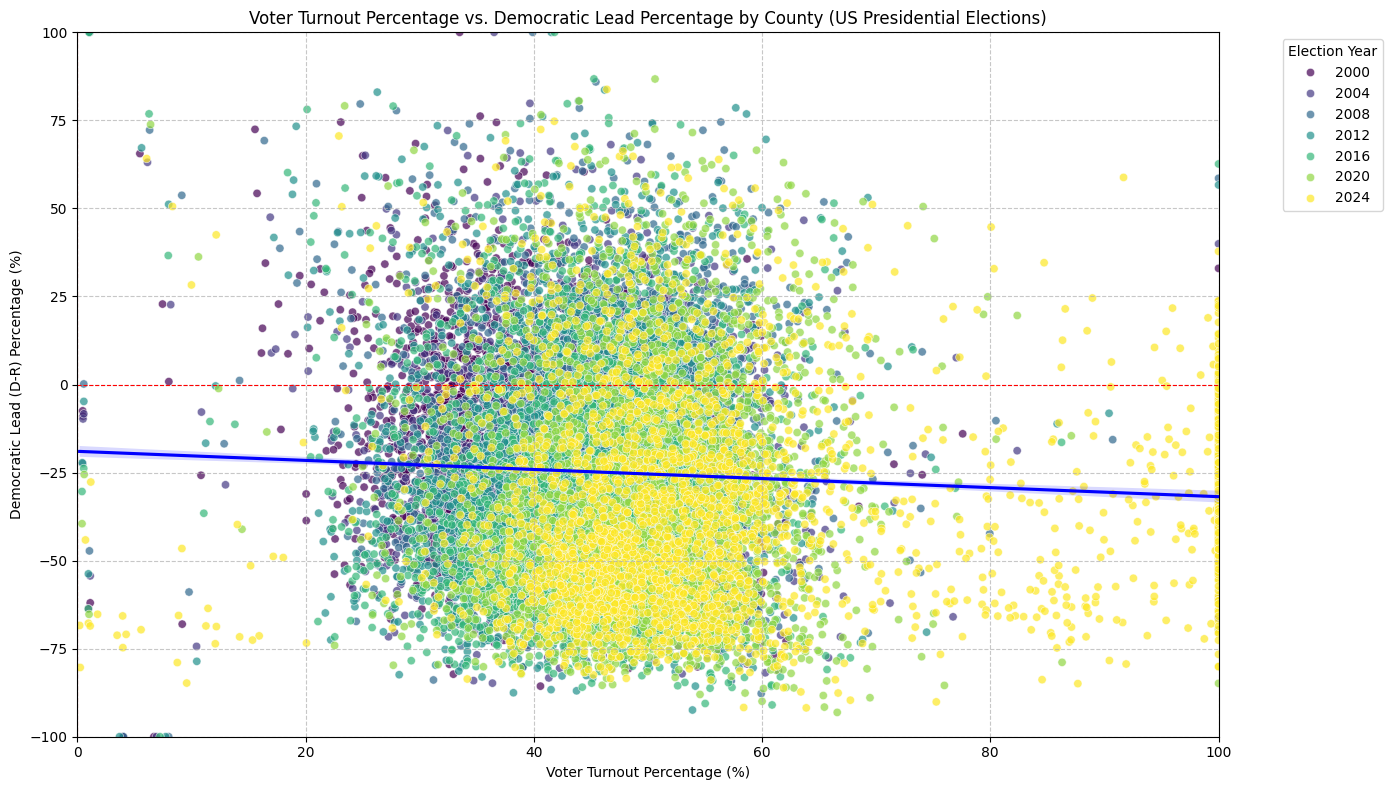

In [241]:
# Create scatterplot for data.
plt.figure(figsize=(14, 8))
sns.scatterplot(x='turnout_percentage', y='Vote_Margin_Percentage', hue='year', data=election_data_cleaned, palette='viridis', alpha=0.7)
sns.regplot(x='turnout_percentage', y='Vote_Margin_Percentage', data=election_data_cleaned, scatter=False, color='blue', ax=plt.gca())
plt.title(f'Voter Turnout Percentage vs. Democratic Lead Percentage by County (US Presidential Elections)')
plt.xlabel('Voter Turnout Percentage (%)')
plt.ylabel('Democratic Lead (D-R) Percentage (%)')
plt.axhline(0, color='red', linestyle='--', linewidth=0.8)
plt.axvline(0, color='red', linestyle='--', linewidth=0.8)
plt.xlim(0, 100)
plt.ylim(-100, 100)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Election Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

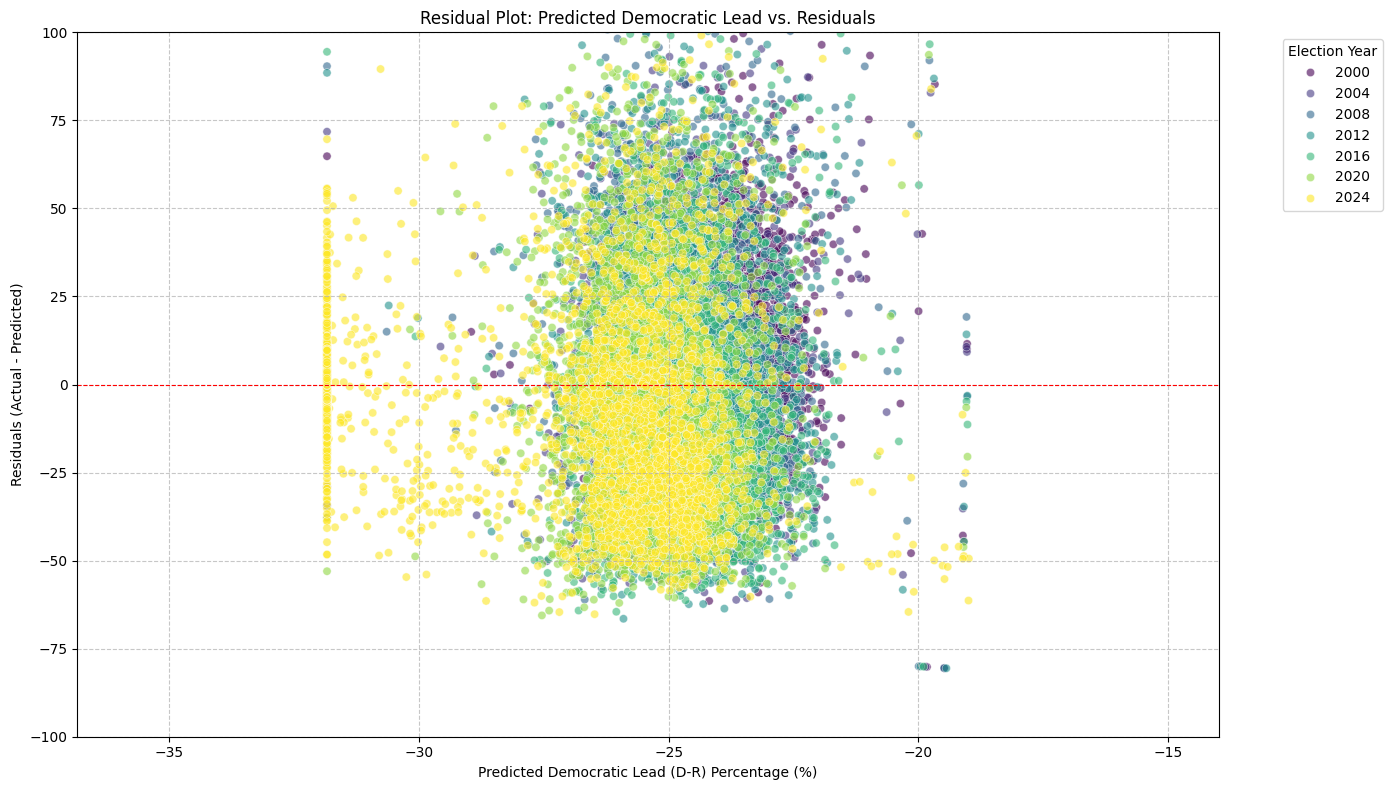

In [242]:
# Calculate expected values for Democratic Lead Percentage.
election_data_cleaned['predicted_democratic_lead'] = model_turnout.predict(election_data_cleaned['turnout_percentage'])

# Calculate residuals.
election_data_cleaned['residuals'] = election_data_cleaned['Vote_Margin_Percentage'] - election_data_cleaned['predicted_democratic_lead']

# Get the actual min and max of the predicted values.
min_pred_lead = election_data_cleaned['predicted_democratic_lead'].min()
max_pred_lead = election_data_cleaned['predicted_democratic_lead'].max()

# Create residual plot.
plt.figure(figsize=(14, 8))
sns.scatterplot(x='predicted_democratic_lead', y='residuals', data=election_data_cleaned, alpha=0.6, hue='year', palette='viridis')
plt.title('Residual Plot: Predicted Democratic Lead vs. Residuals')
plt.xlabel('Predicted Democratic Lead (D-R) Percentage (%)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.axhline(0, color='red', linestyle='--', linewidth=0.8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(min_pred_lead - 5, max_pred_lead + 5)
plt.ylim(-100, 100)
plt.legend(title='Election Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

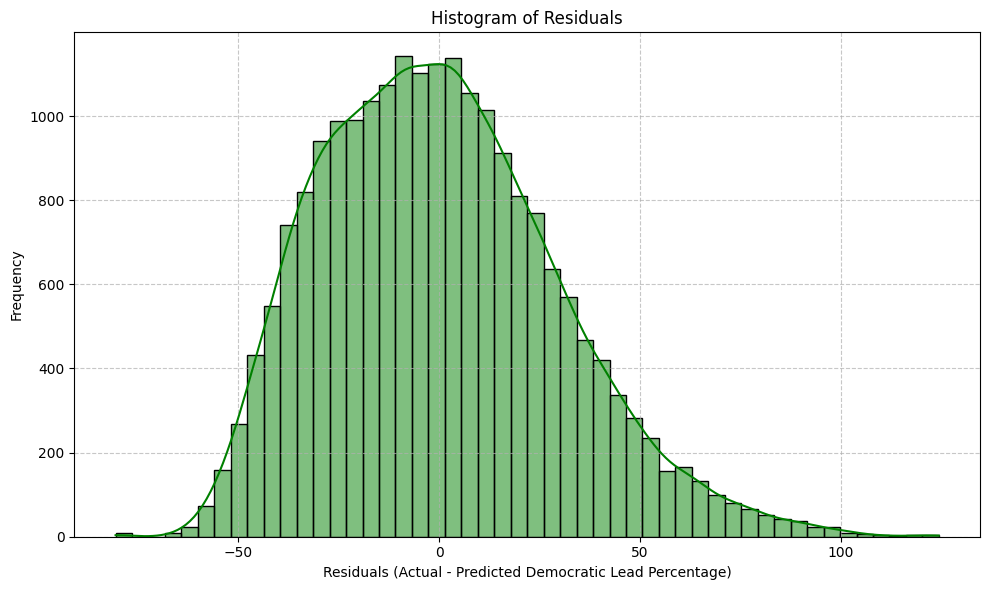

In [243]:
# Plot histogram of residuals.
plt.figure(figsize=(10, 6))
sns.histplot(election_data_cleaned['residuals'], bins=50, kde=True, color='green')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals (Actual - Predicted Democratic Lead Percentage)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()